In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Packages

In [ ]:
#importig necessary libraries 
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from skimage.util import random_noise
from tqdm.notebook import tqdm

# Download CIFAR10 dataset

In [ ]:
# standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=transform)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 74333923.66it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Prepare data & dataloader

In [ ]:
num_workers=1 # number of subprocesses to use for data loading
batch_size=64 
valid_size=0.2 # percentage of training set to use as validation

train_length = len(train_data)
indices=list(range(train_length)) # obtain training indices that will be used for validation
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices) # randomly shuffle data indeces

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

# define data loaders
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=train_sampler)
validation_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=validation_sampler)
test_loader=DataLoader(test_data,shuffle=True,num_workers=num_workers,batch_size=batch_size)


# Visualize some data

In [ ]:
image_dataiter = iter(train_loader)
data = next(image_dataiter)
normal_imgs, normal_labels = data

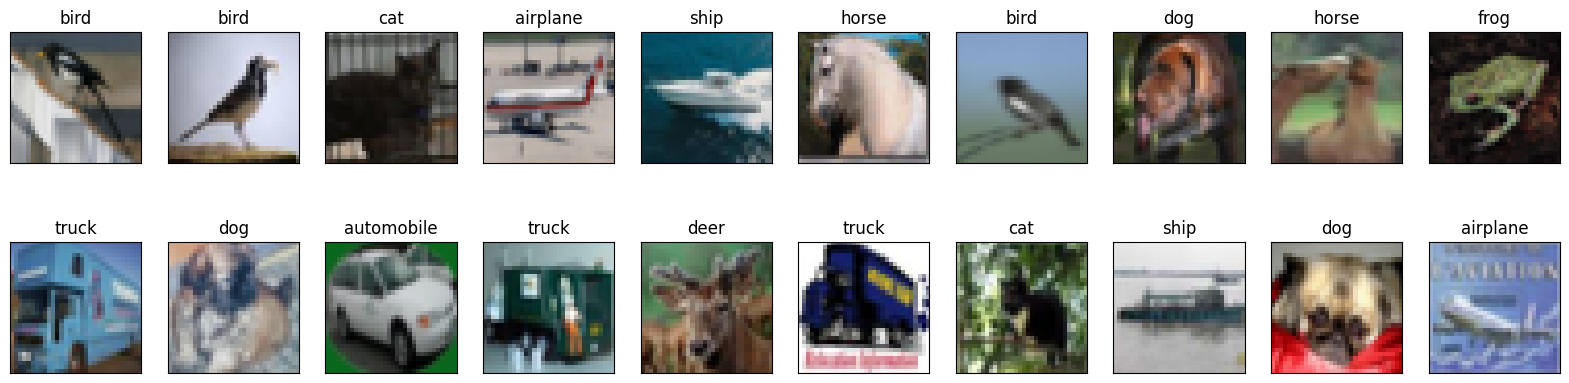

In [ ]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(20,5))
for idx in range(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    RGBshow(normal_imgs[idx])
    ax.set_title(classes[normal_labels[idx]])

# Define Convolutional Neural Network

Neural Network Architecture

In [ ]:
# define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # fully connected layers
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))

        x = self.conv2(x)
        x = nn.functional.relu(x)

        x = self.conv3(x)
        x = nn.functional.relu(x)

        x = self.conv4(x)
        x = nn.functional.relu(x)

        # flattening
        x = x.view(-1, 128 * 2 * 2)

        # fully connected layers
        x = self.fc1(x)
        x = nn.functional.relu(x)

        x = self.fc2(x)
        x = nn.functional.relu(x)

        x = self.fc3(x)
        
        return x


model = CNN()
model.cuda()

print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Train & validation process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of epochs to train the model
n_epochs = 30

#List to store loss to visualize
valid_loss_min = np.Inf # to save the best model with lower validation loss while training process
train_losslist = []
train_acc_list = []
valid_acc_list = []
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1} ...')
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    # Train 
    model.train()
    for data, target in tqdm(train_loader):

        # move tensors to GPU
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        # forward pass
        output = model(data)
        loss = criterion(output, target)
        # backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
        
    # Validate
    model.eval()
    for data, target in tqdm(validation_loader):

        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)

        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        valid_total += target.size(0)
        valid_correct += (predicted == target).sum().item()
    
    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    train_acc = 100 * train_correct / train_total
    valid_acc = 100 * valid_correct / valid_total
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} - Validation Loss: {:.6f} - Training Accuracy: {:.2f}% - Validation Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, valid_loss, train_acc, valid_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'CNN-1.pt')
        valid_loss_min = valid_loss

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)


Epoch 1 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.842516 - Validation Loss: 0.460420 - Training Accuracy: 10.03% - Validation Accuracy: 10.13%
Validation loss decreased (inf --> 0.460420). The new model saved.
Epoch 2 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.840867 - Validation Loss: 0.459747 - Training Accuracy: 12.29% - Validation Accuracy: 16.11%
Validation loss decreased (0.460420 --> 0.459747). The new model saved.
Epoch 3 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.813878 - Validation Loss: 0.425617 - Training Accuracy: 17.19% - Validation Accuracy: 18.77%
Validation loss decreased (0.459747 --> 0.425617). The new model saved.
Epoch 4 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.608522 - Validation Loss: 0.379288 - Training Accuracy: 22.44% - Validation Accuracy: 27.12%
Validation loss decreased (0.425617 --> 0.379288). The new model saved.
Epoch 5 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.462613 - Validation Loss: 0.347587 - Training Accuracy: 30.09% - Validation Accuracy: 33.19%
Validation loss decreased (0.379288 --> 0.347587). The new model saved.
Epoch 6 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.373846 - Validation Loss: 0.334067 - Training Accuracy: 34.92% - Validation Accuracy: 37.20%
Validation loss decreased (0.347587 --> 0.334067). The new model saved.
Epoch 7 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.311553 - Validation Loss: 0.315508 - Training Accuracy: 37.84% - Validation Accuracy: 39.82%
Validation loss decreased (0.334067 --> 0.315508). The new model saved.
Epoch 8 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.253578 - Validation Loss: 0.304553 - Training Accuracy: 41.36% - Validation Accuracy: 42.92%
Validation loss decreased (0.315508 --> 0.304553). The new model saved.
Epoch 9 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.189093 - Validation Loss: 0.295542 - Training Accuracy: 44.85% - Validation Accuracy: 44.56%
Validation loss decreased (0.304553 --> 0.295542). The new model saved.
Epoch 10 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.128557 - Validation Loss: 0.273461 - Training Accuracy: 48.35% - Validation Accuracy: 49.35%
Validation loss decreased (0.295542 --> 0.273461). The new model saved.
Epoch 11 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.074482 - Validation Loss: 0.258269 - Training Accuracy: 51.12% - Validation Accuracy: 52.39%
Validation loss decreased (0.273461 --> 0.258269). The new model saved.
Epoch 12 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.031724 - Validation Loss: 0.250989 - Training Accuracy: 53.20% - Validation Accuracy: 54.14%
Validation loss decreased (0.258269 --> 0.250989). The new model saved.
Epoch 13 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.990131 - Validation Loss: 0.242310 - Training Accuracy: 55.08% - Validation Accuracy: 56.11%
Validation loss decreased (0.250989 --> 0.242310). The new model saved.
Epoch 14 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.949285 - Validation Loss: 0.231958 - Training Accuracy: 57.13% - Validation Accuracy: 57.96%
Validation loss decreased (0.242310 --> 0.231958). The new model saved.
Epoch 15 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.914635 - Validation Loss: 0.225625 - Training Accuracy: 58.87% - Validation Accuracy: 59.75%
Validation loss decreased (0.231958 --> 0.225625). The new model saved.
Epoch 16 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.880113 - Validation Loss: 0.222319 - Training Accuracy: 60.70% - Validation Accuracy: 59.44%
Validation loss decreased (0.225625 --> 0.222319). The new model saved.
Epoch 17 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.846613 - Validation Loss: 0.211389 - Training Accuracy: 61.85% - Validation Accuracy: 62.42%
Validation loss decreased (0.222319 --> 0.211389). The new model saved.
Epoch 18 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.811077 - Validation Loss: 0.215579 - Training Accuracy: 63.84% - Validation Accuracy: 61.08%
Epoch 19 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.782549 - Validation Loss: 0.204439 - Training Accuracy: 65.11% - Validation Accuracy: 63.55%
Validation loss decreased (0.211389 --> 0.204439). The new model saved.
Epoch 20 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.753906 - Validation Loss: 0.199398 - Training Accuracy: 66.19% - Validation Accuracy: 65.18%
Validation loss decreased (0.204439 --> 0.199398). The new model saved.
Epoch 21 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.723817 - Validation Loss: 0.214922 - Training Accuracy: 67.91% - Validation Accuracy: 62.49%
Epoch 22 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.696644 - Validation Loss: 0.191995 - Training Accuracy: 69.09% - Validation Accuracy: 66.26%
Validation loss decreased (0.199398 --> 0.191995). The new model saved.
Epoch 23 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.670562 - Validation Loss: 0.183251 - Training Accuracy: 70.09% - Validation Accuracy: 67.97%
Validation loss decreased (0.191995 --> 0.183251). The new model saved.
Epoch 24 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.648546 - Validation Loss: 0.186752 - Training Accuracy: 71.27% - Validation Accuracy: 67.71%
Epoch 25 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.626146 - Validation Loss: 0.180015 - Training Accuracy: 72.09% - Validation Accuracy: 68.51%
Validation loss decreased (0.183251 --> 0.180015). The new model saved.
Epoch 26 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.603059 - Validation Loss: 0.185709 - Training Accuracy: 73.33% - Validation Accuracy: 67.93%
Epoch 27 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.582669 - Validation Loss: 0.185823 - Training Accuracy: 74.39% - Validation Accuracy: 68.37%
Epoch 28 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.561766 - Validation Loss: 0.170801 - Training Accuracy: 75.13% - Validation Accuracy: 70.65%
Validation loss decreased (0.180015 --> 0.170801). The new model saved.
Epoch 29 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.541566 - Validation Loss: 0.184024 - Training Accuracy: 76.14% - Validation Accuracy: 68.62%
Epoch 30 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.523244 - Validation Loss: 0.174843 - Training Accuracy: 76.98% - Validation Accuracy: 70.31%


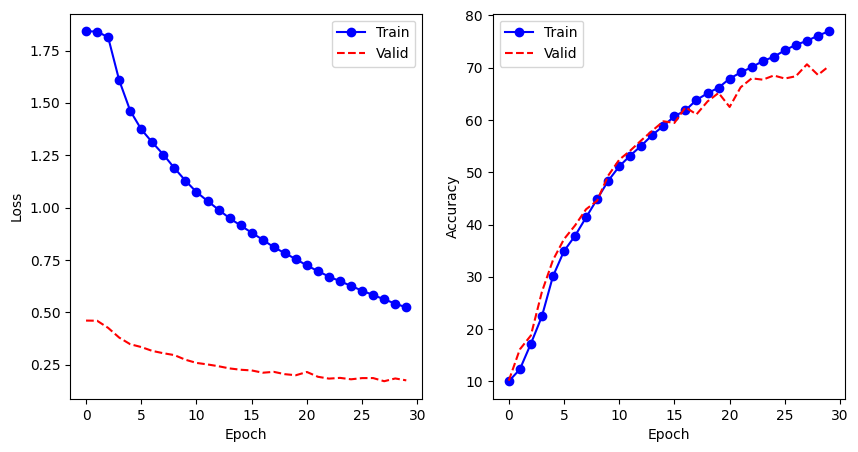

In [ ]:
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Test process

In [ ]:
model.load_state_dict(torch.load('CNN-1.pt'))

# test the model
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = criterion(output, target)
        
        # update test loss
        test_loss += loss.item()*data.size(0)
        # update test accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

# calculate average test loss and accuracy
test_loss = test_loss/len(test_loader.dataset)
test_acc = 100 * test_correct / test_total

# print test statistics
print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%'.format(test_loss, test_acc))

# add to history
history['test_loss'] = test_loss
history['test_acc'] = test_acc

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.850300 - Test Accuracy: 70.60%


# Optimized Convolutional Neural Network

Neural Network Architecture

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


model = CNN()
model.cuda()

print(model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

loss function & optimizer

In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()

train & validation process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of epochs to train the model
n_epochs = 30
learning_rate = 0.001

#List to store loss to visualize
valid_loss_min = np.Inf
train_losslist = []
train_acc_list = []
valid_acc_list = []
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1} ...')
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0

    #Changing the optimizer setting while training
    if epoch <= 10:
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif epoch > 10 and epoch <= 25:
      optimizer = optim.Adam(model.parameters(), lr=(learning_rate)/10)
    else:
     optimizer = optim.Adam(model.parameters(), lr=(learning_rate)/50)  
    
    
    # Train
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
       
        optimizer.zero_grad()
        # forward pass
        output = model(data)
  
        loss = criterion(output, target)
        # backward pass
        loss.backward()
        optimizer.step()

        # update training loss
        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
        
   
    #validate
    model.eval()
    for data, target in tqdm(validation_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = criterion(output, target)

        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        valid_total += target.size(0)
        valid_correct += (predicted == target).sum().item()
    
    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    train_acc = 100 * train_correct / train_total
    valid_acc = 100 * valid_correct / valid_total
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} - Validation Loss: {:.6f} - Training Accuracy: {:.2f}% - Validation Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, valid_loss, train_acc, valid_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'CNN-2.pt')
        valid_loss_min = valid_loss

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)


Epoch 1 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.180916 - Validation Loss: 0.288936 - Training Accuracy: 45.30% - Validation Accuracy: 51.58%
Validation loss decreased (inf --> 0.288936). The new model saved.
Epoch 2 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.832085 - Validation Loss: 0.178470 - Training Accuracy: 63.17% - Validation Accuracy: 68.22%
Validation loss decreased (0.288936 --> 0.178470). The new model saved.
Epoch 3 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.674416 - Validation Loss: 0.175971 - Training Accuracy: 70.39% - Validation Accuracy: 70.01%
Validation loss decreased (0.178470 --> 0.175971). The new model saved.
Epoch 4 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.587035 - Validation Loss: 0.149452 - Training Accuracy: 74.14% - Validation Accuracy: 74.27%
Validation loss decreased (0.175971 --> 0.149452). The new model saved.
Epoch 5 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.516723 - Validation Loss: 0.141533 - Training Accuracy: 77.43% - Validation Accuracy: 75.36%
Validation loss decreased (0.149452 --> 0.141533). The new model saved.
Epoch 6 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.460843 - Validation Loss: 0.159185 - Training Accuracy: 79.89% - Validation Accuracy: 74.05%
Epoch 7 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.414585 - Validation Loss: 0.131205 - Training Accuracy: 81.78% - Validation Accuracy: 78.46%
Validation loss decreased (0.141533 --> 0.131205). The new model saved.
Epoch 8 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.380146 - Validation Loss: 0.138604 - Training Accuracy: 83.49% - Validation Accuracy: 78.25%
Epoch 9 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.340046 - Validation Loss: 0.129302 - Training Accuracy: 85.09% - Validation Accuracy: 79.17%
Validation loss decreased (0.131205 --> 0.129302). The new model saved.
Epoch 10 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.312630 - Validation Loss: 0.131203 - Training Accuracy: 86.30% - Validation Accuracy: 79.67%
Epoch 11 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.294032 - Validation Loss: 0.125332 - Training Accuracy: 87.19% - Validation Accuracy: 80.18%
Validation loss decreased (0.129302 --> 0.125332). The new model saved.
Epoch 12 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.162425 - Validation Loss: 0.121491 - Training Accuracy: 92.78% - Validation Accuracy: 83.00%
Validation loss decreased (0.125332 --> 0.121491). The new model saved.
Epoch 13 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.127656 - Validation Loss: 0.129652 - Training Accuracy: 94.22% - Validation Accuracy: 83.05%
Epoch 14 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.112634 - Validation Loss: 0.137347 - Training Accuracy: 94.87% - Validation Accuracy: 82.95%
Epoch 15 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.100151 - Validation Loss: 0.137984 - Training Accuracy: 95.47% - Validation Accuracy: 83.26%
Epoch 16 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.093767 - Validation Loss: 0.142140 - Training Accuracy: 95.82% - Validation Accuracy: 83.32%
Epoch 17 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.083410 - Validation Loss: 0.148182 - Training Accuracy: 96.22% - Validation Accuracy: 83.24%
Epoch 18 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.079734 - Validation Loss: 0.151137 - Training Accuracy: 96.39% - Validation Accuracy: 83.23%
Epoch 19 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.072059 - Validation Loss: 0.155732 - Training Accuracy: 96.76% - Validation Accuracy: 83.41%
Epoch 20 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.066533 - Validation Loss: 0.163573 - Training Accuracy: 97.11% - Validation Accuracy: 83.28%
Epoch 21 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.061899 - Validation Loss: 0.167425 - Training Accuracy: 97.31% - Validation Accuracy: 83.60%
Epoch 22 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.059344 - Validation Loss: 0.176051 - Training Accuracy: 97.50% - Validation Accuracy: 83.34%
Epoch 23 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.056647 - Validation Loss: 0.169233 - Training Accuracy: 97.50% - Validation Accuracy: 83.30%
Epoch 24 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.050494 - Validation Loss: 0.169639 - Training Accuracy: 97.88% - Validation Accuracy: 83.37%
Epoch 25 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.049501 - Validation Loss: 0.179176 - Training Accuracy: 97.85% - Validation Accuracy: 83.32%
Epoch 26 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.047191 - Validation Loss: 0.179403 - Training Accuracy: 98.00% - Validation Accuracy: 82.85%
Epoch 27 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.039163 - Validation Loss: 0.184048 - Training Accuracy: 98.36% - Validation Accuracy: 83.37%
Epoch 28 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.038579 - Validation Loss: 0.184361 - Training Accuracy: 98.44% - Validation Accuracy: 83.55%
Epoch 29 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.036496 - Validation Loss: 0.189392 - Training Accuracy: 98.49% - Validation Accuracy: 83.46%
Epoch 30 ...


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.036124 - Validation Loss: 0.193636 - Training Accuracy: 98.49% - Validation Accuracy: 83.52%


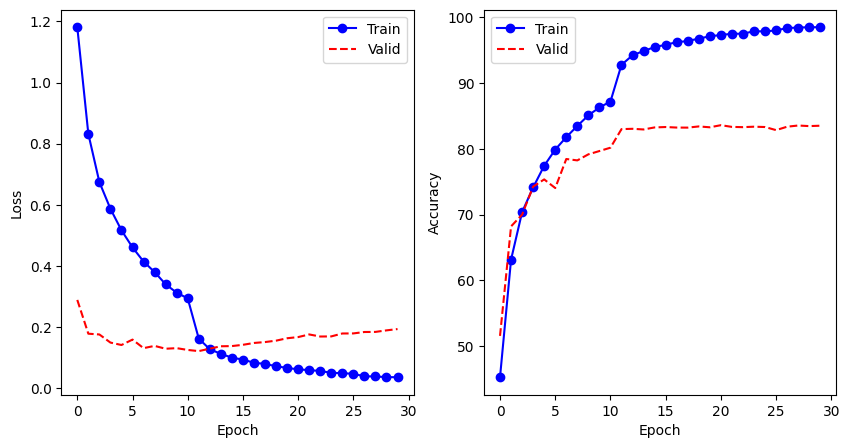

In [ ]:
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

test process

In [ ]:
model.load_state_dict(torch.load('CNN-2.pt'))

# test the model
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)
        # update test accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

# calculate average test loss and accuracy
test_loss = test_loss/len(test_loader.dataset)
test_acc = 100 * test_correct / test_total

# print test statistics
print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%'.format(test_loss, test_acc))

# add to history
history['test_loss'] = test_loss
history['test_acc'] = test_acc

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.611401 - Test Accuracy: 82.76%


# Prepare data & dataloader

Add salt & pepper noise to data

In [ ]:
class SaltAndPepper:
    # add salt & pepper to noise by a specific factor
    def __init__(self, noise_factor):
        self.noise_factor = noise_factor

    def __call__(self, img):
        salt_img = torch.tensor(random_noise(img, mode="s&p", clip=True, amount=self.noise_factor))
        return salt_img, img

In [ ]:
noise_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    SaltAndPepper(0.07)
])

download & transform data

In [ ]:
noisy_train_data=datasets.CIFAR10('noisy_data',train=True,download=True,transform=noise_transform)
noisy_test_data=datasets.CIFAR10('noisy_data',train=False,download=True,transform=noise_transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 47444093.50it/s]


Extracting noisy_data/cifar-10-python.tar.gz to noisy_data
Files already downloaded and verified


In [ ]:
num_workers=1 # number of subprocesses to use for data loading
batch_size=64 
valid_size=0.2 # percentage of training set to use as validation
train_length = len(noisy_train_data)
indices=list(range(train_length)) # obtain training indices that will be used for validation
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices) # randomly shuffle data indeces

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

# define data loaders
noisy_train_loader=DataLoader(noisy_train_data,num_workers=num_workers,batch_size=batch_size,sampler=train_sampler)
noisy_validation_loader=DataLoader(noisy_train_data,num_workers=num_workers,batch_size=batch_size,sampler=validation_sampler)
noisy_test_loader=DataLoader(noisy_test_data,shuffle=True,num_workers=num_workers,batch_size=batch_size)


visualize some data

Noisy images

In [ ]:
noise_dataiter = iter(noisy_train_loader)
data = next(noise_dataiter)
(noise_imgs, normal_imgs), noise_labels = data
print(normal_imgs.size())

torch.Size([64, 3, 32, 32])


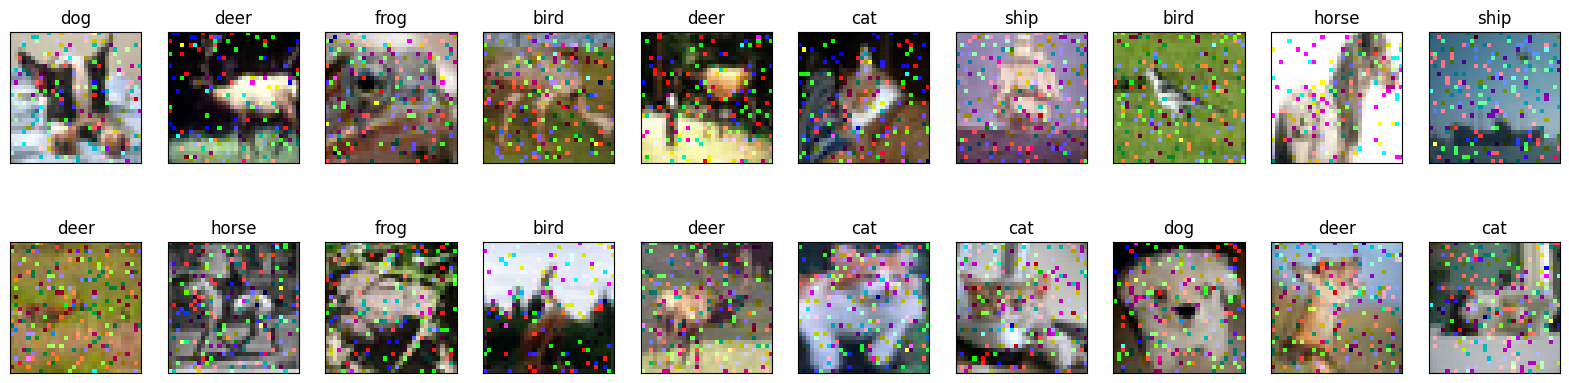

In [ ]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(20,5))
for idx in range(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    RGBshow(noise_imgs[idx])
    ax.set_title(classes[noise_labels[idx]])

Normal images

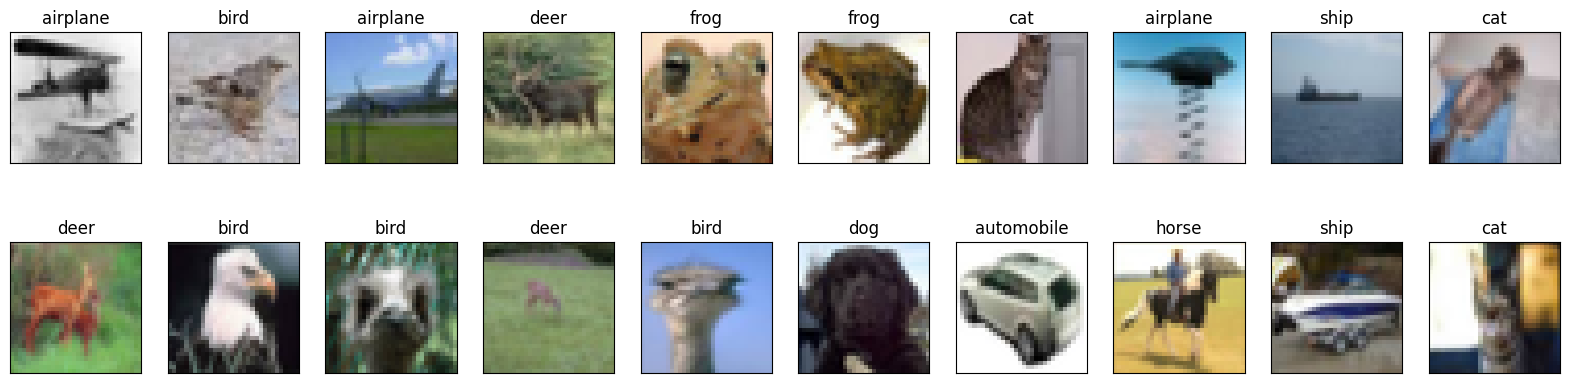

In [ ]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(20,5))
for idx in range(20):
    ax=fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    RGBshow(normal_imgs[idx])
    ax.set_title(classes[noise_labels[idx]])

In [ ]:
noise_imgs[idx].shape

torch.Size([3, 32, 32])

# Define U-Net

Neural Network Architecture

In [ ]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, padding=padding),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(out_channels, out_channels, size, padding=padding, stride=stride),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        # x size = (batch_size, channel, width, height)
        x = self.convs(x)
        return x


class DeConv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2):
        super().__init__()
        self.deConv = nn.ConvTranspose2d(in_channels, out_channels, size,
                                         padding=1, stride=2, output_padding=1)
        self.convs = Conv_block(out_channels * 2, out_channels, size, padding, dropout)

    def forward(self, x, residual):
        # x size = (batch_size, channel, width, height)
        x = self.deConv(x)
        x = torch.cat([x, residual], 1)
        x = self.convs(x)
        return x


class Unet(nn.Module):
    # initializers
    def __init__(self, d=64, out_channels=3, dropout=0.2):
        super().__init__()

        # Unet encoder
        self.conv_blocks = nn.ModuleList([
            Conv_block(3, d, dropout=dropout),
            Conv_block(d, 2 * d, stride=2, dropout=dropout),
            Conv_block(2 * d, 4 * d, stride=2, dropout=dropout),
            Conv_block(4 * d, 8 * d, stride=2, dropout=dropout),
            Conv_block(8 * d, 16 * d, stride=2, dropout=dropout)
        ])

        # Unet decoder
        self.deConv_blocks = nn.ModuleList([
            DeConv_block(16 * d, 8 * d, dropout=dropout),
            DeConv_block(8 * d, 4 * d, dropout=dropout),
            DeConv_block(4 * d, 2 * d, dropout=dropout),
            DeConv_block(2 * d, d, dropout=dropout),
        ])

        self.output_conv = nn.Conv2d(d, out_channels, 3, padding=1)
        self.float()

    # forward method
    def forward(self, x):
        x1 = self.conv_blocks[0](x)
        x2 = self.conv_blocks[1](x1)
        x3 = self.conv_blocks[2](x2)
        x4 = self.conv_blocks[3](x3)
        x5 = self.conv_blocks[4](x4)

        x = self.deConv_blocks[0](x5, x4)
        x = self.deConv_blocks[1](x, x3)
        x = self.deConv_blocks[2](x, x2)
        x = self.deConv_blocks[3](x, x1)

        x = self.output_conv(x)

        return x

model = Unet()

In [ ]:
model

ModuleDict(
  (generator): Unet(
    (conv_blocks): ModuleList(
      (0): Conv_block(
        (convs): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): LeakyReLU(negative_slope=0.1, inplace=True)
          (6): Dropout(p=0.2, inplace=False)
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Conv_block(
        (convs): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 3, 32, 32), expand_nested=True)
model_graph.visual_graph.render("Unet", format="png")

'Unet.png'

loss function & optimizer

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train & validation process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
epoch = 20
valid_loss_min = np.Inf

model.to(device)
history = {'train': [], 'valid': []}
for i in range(epoch):
    print(f'Epoch {i+1} ...')
    
    model.train()
    sum_train_mse = 0
    training_steps = 0
    for (x, y), _ in tqdm(noisy_train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        
        sum_train_mse += loss.cpu().item()
        training_steps += 1

        loss.backward()
        optimizer.step()

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for (x, y), _ in tqdm(noisy_validation_loader):

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(x)
        loss = criterion(output, y)
        
        valid_loss = loss.cpu().item()
        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'UNET-1-0.07.pt')
        valid_loss_min = valid_loss

    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1}, Average Train MSE: {sum_train_mse / training_steps}, Average Validation MSE: {sum_valid_mse / valid_steps}')

Epoch 1 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.008276). The new model saved
Epoch 1, Average Train MSE: 0.02589854387789965, Average Validation MSE: 0.009375400301424941
Epoch 2 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.008276 --> 0.006622). The new model saved
Epoch 2, Average Train MSE: 0.011325330665707588, Average Validation MSE: 0.0066121974811669745
Epoch 3 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.006622 --> 0.004066). The new model saved
Epoch 3, Average Train MSE: 0.008723432382941246, Average Validation MSE: 0.003539481421244467
Epoch 4 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Average Train MSE: 0.007707739654928446, Average Validation MSE: 0.0063990874239688465
Epoch 5 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Average Train MSE: 0.007242831186950207, Average Validation MSE: 0.004867823382210769
Epoch 6 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.004066 --> 0.002631). The new model saved
Epoch 6, Average Train MSE: 0.006680698312819004, Average Validation MSE: 0.0023755336737936467
Epoch 7 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.002631 --> 0.002554). The new model saved
Epoch 7, Average Train MSE: 0.006375023477524519, Average Validation MSE: 0.0023515838417847443
Epoch 8 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8, Average Train MSE: 0.006092726903036237, Average Validation MSE: 0.003019371683928807
Epoch 9 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9, Average Train MSE: 0.006037048038467765, Average Validation MSE: 0.005150228228633571
Epoch 10 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.002554 --> 0.001438). The new model saved
Epoch 10, Average Train MSE: 0.005729988810420037, Average Validation MSE: 0.0013010709599894322
Epoch 11 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.001438 --> 0.001217). The new model saved
Epoch 11, Average Train MSE: 0.005418743133544922, Average Validation MSE: 0.001422586410371646
Epoch 12 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12, Average Train MSE: 0.0052083646140992645, Average Validation MSE: 0.001762750516289691
Epoch 13 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13, Average Train MSE: 0.005104004853591323, Average Validation MSE: 0.0016121985665136936
Epoch 14 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14, Average Train MSE: 0.004740643934533, Average Validation MSE: 0.0018968394027643238
Epoch 15 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15, Average Train MSE: 0.005112435646355152, Average Validation MSE: 0.0011618589592362
Epoch 16 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16, Average Train MSE: 0.0046869679469615224, Average Validation MSE: 0.0013019836390580817
Epoch 17 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17, Average Train MSE: 0.004700652807205915, Average Validation MSE: 0.0013259076187090509
Epoch 18 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18, Average Train MSE: 0.0045633885644376275, Average Validation MSE: 0.001380531846954944
Epoch 19 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19, Average Train MSE: 0.0045682021100074055, Average Validation MSE: 0.0015082081051685722
Epoch 20 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20, Average Train MSE: 0.004472101965919137, Average Validation MSE: 0.00313851656837116


In [ ]:
# model_save_name = 'UNET-1-0.07.pt'
# path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
# torch.save(model.state_dict(), path)

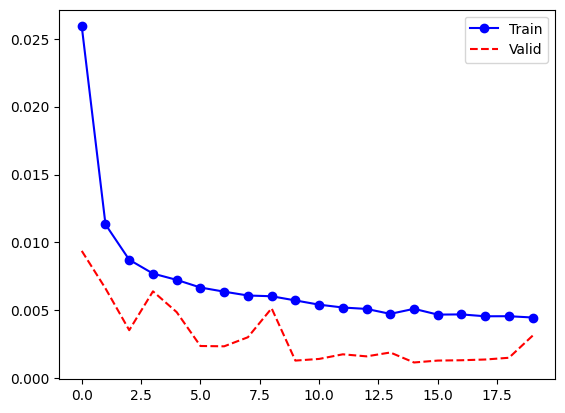

In [ ]:
plt.plot(history['train'], 'bo-', label='Train')
plt.plot(history['valid'], 'r--', label='Valid')
plt.legend()

Noisy test loader

test process

In [ ]:
model_save_name = 'UNET-1-0.07.pt'
path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model.eval()

with torch.no_grad():
    noise_imgs = noise_imgs.to(device)
    UNET_denoised_images = model(noise_imgs).cpu()

noise_imgs = noise_imgs.cpu()

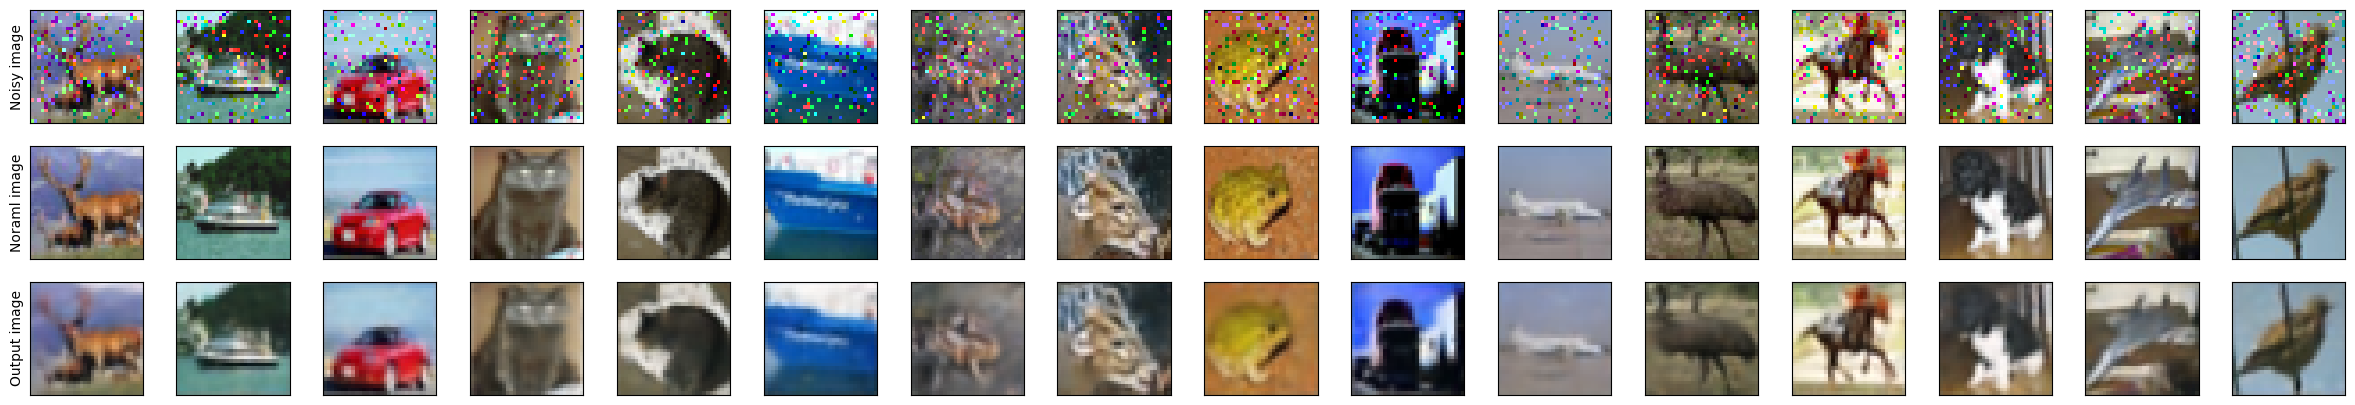

In [ ]:
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(16):
    ax=fig.add_subplot(3, 16, idx+1, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noisy image')
    RGBshow(noise_imgs[idx])

    ax=fig.add_subplot(3, 16, idx+17, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noraml image')
    RGBshow(normal_imgs[idx])

    ax=fig.add_subplot(3, 16, idx+33, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Output image')
    RGBshow(UNET_denoised_images[idx])

# Optimized U-Net (GAN)

Neural Network Architecture

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, label_channels=3, input_channels=3, d=64):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(label_channels + input_channels, d, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d),

            nn.Conv2d(d, d*2, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*2),

            nn.Conv2d(d*2, d*4, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*4),

            nn.Conv2d(d*4, d*8, 3, 2, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(d*8),

            nn.Conv2d(d*8, 1, 3, 2, 1),
        )
        self.float()

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.convs(x)

        return x

In [ ]:
generator = Unet()
discriminator = Discriminator()

model = nn.ModuleDict({'generator': generator, 'discriminator': discriminator})

loss function & optimizer

In [ ]:
generator_l2_loss = nn.MSELoss()
geratator_gan_loss = nn.BCEWithLogitsLoss()

discriminator_gan_loss = nn.BCEWithLogitsLoss()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

train & validation process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
epoch = 20
lam = 100
valid_loss_min = np.Inf

model.to(device)
history = {'train': [], 'valid': []}
for i in range(epoch):
    print(f'Epoch {i+1} ...')
    
    model.train()
    sum_train_mse = 0
    training_steps = 0
    for (x, y), _ in tqdm(noisy_train_loader):
    
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        
        x = x.to(device)
        y = y.to(device)

        # Train discriminator:
        D_result_real = model['discriminator'](x, y).squeeze().float()
        D_real_loss = discriminator_gan_loss(D_result_real, torch.zeros(D_result_real.size(), device=device))

        with torch.no_grad():
            G_result = model['generator'](x).float()
        D_result_fake = discriminator(x, G_result).squeeze().float()
        D_fake_loss = discriminator_gan_loss(D_result_fake, torch.ones(D_result_fake.size(), device=device))
        D_train_loss = (D_real_loss + D_fake_loss) * 0.5

        D_train_loss.backward()
        discriminator_optimizer.step()

        # Train generator
        G_result = model['generator'](x).float()
        D_result_fake = model['discriminator'](x, G_result).squeeze().float()
        G_gan_loss = geratator_gan_loss(D_result_fake, torch.zeros(D_result_fake.size(), device=device))
        G_mse_loss = generator_l2_loss(G_result, y)
        G_train_loss = G_gan_loss + G_mse_loss * lam

        G_train_loss.backward()
        generator_optimizer.step()

        sum_train_mse += G_mse_loss.cpu().item()
        training_steps += 1

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for (x, y), _ in tqdm(noisy_validation_loader):

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model['generator'](x)
        loss = criterion(output, y)
        
        valid_loss = loss.cpu().item()
        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'GAN-UNET-0.07.pt')
        valid_loss_min = valid_loss


    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1}, Average Train MSE: {sum_train_mse / training_steps}, Average Validation MSE: {sum_valid_mse / valid_steps}')

Epoch 1 ...


  0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b74c5d1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b74c5d1b0>assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.003121). The new model saved
Epoch 1, Average Train MSE: 0.007849581962823867, Average Validation MSE: 0.003111231179350311
Epoch 2 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2, Average Train MSE: 0.008457244128733873, Average Validation MSE: 0.0035844977328162286
Epoch 3 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3, Average Train MSE: 0.00933293367549777, Average Validation MSE: 0.004427151156850396
Epoch 4 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Average Train MSE: 0.00987521050721407, Average Validation MSE: 0.004299278397730012
Epoch 5 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Average Train MSE: 0.010260106071829795, Average Validation MSE: 0.004736475263882405
Epoch 6 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6, Average Train MSE: 0.010064362169802188, Average Validation MSE: 0.004882660952461943
Epoch 7 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7, Average Train MSE: 0.009878696070611476, Average Validation MSE: 0.0037638819361236063
Epoch 8 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8, Average Train MSE: 0.010016754993796348, Average Validation MSE: 0.004100357932720784
Epoch 9 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9, Average Train MSE: 0.01038801921904087, Average Validation MSE: 0.0057256837452577935
Epoch 10 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10, Average Train MSE: 0.010419773241877556, Average Validation MSE: 0.005150042293344144
Epoch 11 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11, Average Train MSE: 0.010627232493460178, Average Validation MSE: 0.004253591354461802
Epoch 12 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12, Average Train MSE: 0.010574478086829186, Average Validation MSE: 0.00455160137669296
Epoch 13 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13, Average Train MSE: 0.010886322359740734, Average Validation MSE: 0.0049762392363208495
Epoch 14 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14, Average Train MSE: 0.011284198193252087, Average Validation MSE: 0.0051695269526569705
Epoch 15 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15, Average Train MSE: 0.01175284129679203, Average Validation MSE: 0.0050487322673486296
Epoch 16 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16, Average Train MSE: 0.011176214335858822, Average Validation MSE: 0.004779887531000148
Epoch 17 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17, Average Train MSE: 0.011125335569679737, Average Validation MSE: 0.004777642411838291
Epoch 18 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18, Average Train MSE: 0.011936238074302673, Average Validation MSE: 0.005088875372745809
Epoch 19 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19, Average Train MSE: 0.011459432026743889, Average Validation MSE: 0.004947123538916278
Epoch 20 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20, Average Train MSE: 0.011865649497509003, Average Validation MSE: 0.005277157574298845


In [ ]:
# model_save_name = 'GAN-UNET-0.07.pt'
# path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
# torch.save(model.state_dict(), path)

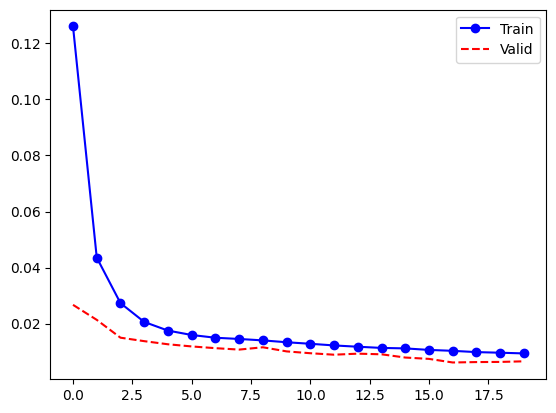

In [ ]:
plt.plot(history['train'], 'bo-', label='Train')
plt.plot(history['valid'], 'r--', label='Valid')
plt.legend()

test process

In [ ]:
model_save_name = 'GAN-UNET-0.07.pt'
path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model.eval()

with torch.no_grad():
    noise_imgs = noise_imgs.to(device)
    GAN_denoised_images = model['generator'](noise_imgs).cpu()

noise_imgs = noise_imgs.cpu()

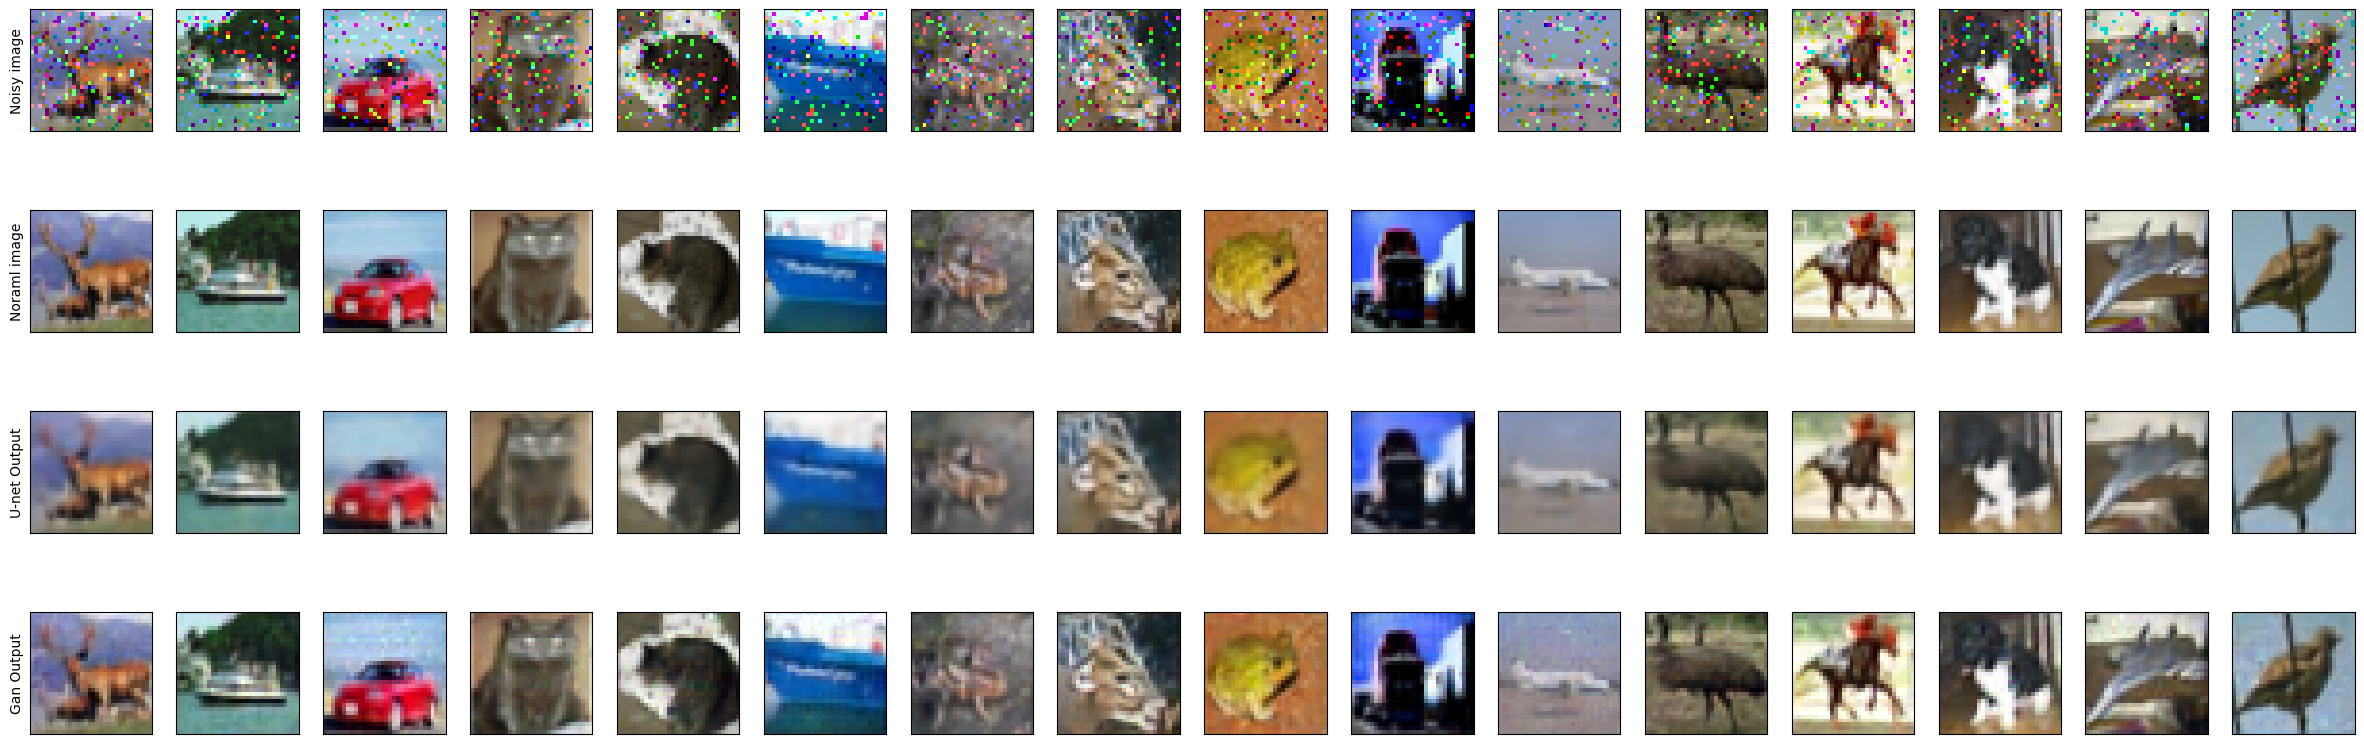

In [ ]:
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,10))
for idx in range(16):
    ax=fig.add_subplot(4, 16, idx+1, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noisy image')
    RGBshow(noise_imgs[idx])

    ax=fig.add_subplot(4, 16, idx+17, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noraml image')
    RGBshow(normal_imgs[idx])

    ax=fig.add_subplot(4, 16, idx+33, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('U-net Output')
    RGBshow(UNET_denoised_images[idx])

    ax=fig.add_subplot(4, 16, idx+49, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Gan Output')
    RGBshow(GAN_denoised_images[idx])

# Optimized U-Net (Attention)

Neural Network Architecture

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels_g, in_channels_x, inter_channels):
        super(AttentionBlock, self).__init__()
        self.theta_x = nn.Conv2d(in_channels_x, inter_channels, kernel_size=1, stride=1, padding=0)
        self.phi_g = nn.Conv2d(in_channels_g, inter_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.psi_f = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        theta_x = self.theta_x(x)
        phi_g = self.phi_g(g)
        f = self.relu(theta_x + phi_g)
        psi_f = self.psi_f(f)
        rate = self.sigmoid(psi_f)
        att_x = torch.mul(x, rate)
        return att_x


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetWithAttention, self).__init__()

        #Down
        #Layer1
        self.conv1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Layer2
        self.conv2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Layer3
        self.conv3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Layer4
        self.conv4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Layer5
        self.conv5 = ConvBlock(512, 1024)

        #Up
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attention6 = AttentionBlock(512, 512, 256)
        self.conv6 = ConvBlock(1024, 512)
        #Layer1
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attention7 = AttentionBlock(256, 256, 128)
        self.conv7 = ConvBlock(512, 256)
        #Layer2
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attention8 = AttentionBlock(128, 128, 64)
        self.conv8 = ConvBlock(256, 128)
        #Layer3
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attention9 = AttentionBlock(64, 64, 32)
        self.conv9 = ConvBlock(128, 64)
        #Layer4
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):

        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool1(x1))
        x3 = self.conv3(self.pool2(x2))
        x4 = self.conv4(self.pool3(x3))
        x5 = self.conv5(self.pool4(x4))

        # Decoder
        x = self.conv6(torch.cat([self.attention6(g=x4, x=self.up6(x5)), x4], dim=1))
        x = self.conv7(torch.cat([self.attention7(g=x3, x=self.up7(x)), x3], dim=1))
        x = self.conv8(torch.cat([self.attention8(g=x2, x=self.up8(x)), x2], dim=1))
        x = self.conv9(torch.cat([self.attention9(g=x1, x=self.up9(x)), x1], dim=1))

        # Output
        out = self.conv10(x)

        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  UNetWithAttention()

loss function & optimizer

In [ ]:
criterion = nn.MSELoss().to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train & validation process

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch = 20
valid_loss_min = np.Inf

model.to(device)
history = {'train': [], 'valid': []}

for i in range(epoch):
    sum_train_mse = 0
    training_steps = 0
    print(f'Epoch {i+1} ...')
    
    #Train
    model.train()
    for (noisy_image, normal_image), _ in tqdm(noisy_train_loader):
    
        optimizer.zero_grad()

        noisy_image.to(device)
        normal_image.to(device)

        # Forward pass

        outputs = model(noisy_image.to(device)).to(device)
 
        loss = criterion(outputs, normal_image.to(device)).to(device)

        sum_train_mse += loss.cpu().item()
        training_steps += 1

        loss.backward()
        optimizer.step()

    #Validate
    model.eval()
    sum_valid_mse = 0
    valid_steps = 0

    with torch.no_grad():
        for (noisy_image, normal_image), _ in tqdm(noisy_validation_loader):

            noisy_image.to(device)
            normal_image.to(device)

            outputs = model(noisy_image.to(device)).to(device)

     

            loss = criterion(outputs, normal_image.to(device)).to(device)
            valid_loss = loss.cpu().item()
            sum_valid_mse += loss.cpu().item()
            valid_steps += 1

    if valid_loss <= valid_loss_min:

        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'Attention-UNET-0.07.pt')
        valid_loss_min = valid_loss

    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1}, Average Train MSE: {sum_train_mse / training_steps}, Average Validation MSE: {sum_valid_mse / valid_steps}')

Epoch 1 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.000431). The new model saved
Epoch 1, Average Train MSE: 0.0006157307683955878, Average Validation MSE: 0.000508391193802332
Epoch 2 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2, Average Train MSE: 0.0005383178568445146, Average Validation MSE: 0.0006003601663407816
Epoch 3 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.000431 --> 0.000368). The new model saved
Epoch 3, Average Train MSE: 0.0004861793301533908, Average Validation MSE: 0.00040058735635718865
Epoch 4 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.000368 --> 0.000269). The new model saved
Epoch 4, Average Train MSE: 0.00043956308821216226, Average Validation MSE: 0.00031798633329338944
Epoch 5 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Average Train MSE: 0.0004134707667399198, Average Validation MSE: 0.0004733099357838962
Epoch 6 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6, Average Train MSE: 0.00037386462420690807, Average Validation MSE: 0.0003116546909823112
Epoch 7 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7, Average Train MSE: 0.000353637907654047, Average Validation MSE: 0.0005077263162394238
Epoch 8 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8, Average Train MSE: 0.0003215733310906216, Average Validation MSE: 0.00023288669067977744
Epoch 9 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9, Average Train MSE: 0.0002990280881989747, Average Validation MSE: 0.0005024664191481699
Epoch 10 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10, Average Train MSE: 0.0002999393138801679, Average Validation MSE: 0.00028219839969907955
Epoch 11 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.000269 --> 0.000153). The new model saved
Epoch 11, Average Train MSE: 0.0002815160696860403, Average Validation MSE: 0.00018701707417068255
Epoch 12 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12, Average Train MSE: 0.00024750628352630886, Average Validation MSE: 0.00026010299536360985
Epoch 13 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13, Average Train MSE: 0.00027443670914508404, Average Validation MSE: 0.00037764688078047127
Epoch 14 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14, Average Train MSE: 0.00022380608606617898, Average Validation MSE: 0.00019310147842246993
Epoch 15 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15, Average Train MSE: 0.00021722565426025538, Average Validation MSE: 0.0002116163411017531
Epoch 16 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.000153 --> 0.000145). The new model saved
Epoch 16, Average Train MSE: 0.00021787437923485414, Average Validation MSE: 0.0001921799921083626
Epoch 17 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17, Average Train MSE: 0.00020525611320044846, Average Validation MSE: 0.0001826425073527476
Epoch 18 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18, Average Train MSE: 0.00022767205784330144, Average Validation MSE: 0.00017245005720567882
Epoch 19 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.000145 --> 0.000135). The new model saved
Epoch 19, Average Train MSE: 0.0001935332705033943, Average Validation MSE: 0.0001306982978267868
Epoch 20 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20, Average Train MSE: 0.00018708535195328295, Average Validation MSE: 0.00017330941110537952


In [ ]:
model_save_name = 'Attention-UNET-0.07.pt'
path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
torch.save(model.state_dict(), path)

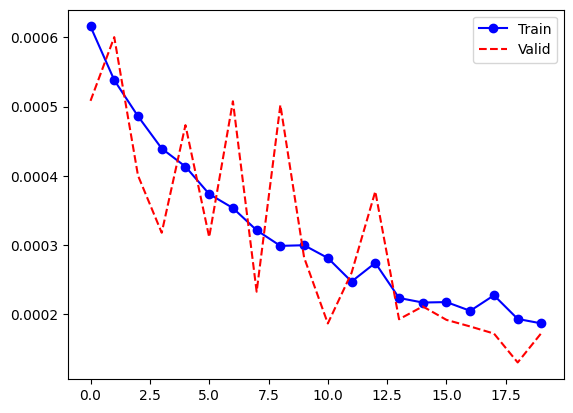

In [ ]:
plt.plot(history['train'], 'bo-', label='Train')
plt.plot(history['valid'], 'r--', label='Valid')
plt.legend()

test process

In [ ]:
model_save_name = 'Attention-UNET-0.07.pt'
path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load('Attention-UNET-0.07.pt'))

model.eval()

with torch.no_grad():
    noise_imgs = noise_imgs.to(device)
    ATTENTION_denoised_images = model(noise_imgs).cpu()

noise_imgs = noise_imgs.cpu()

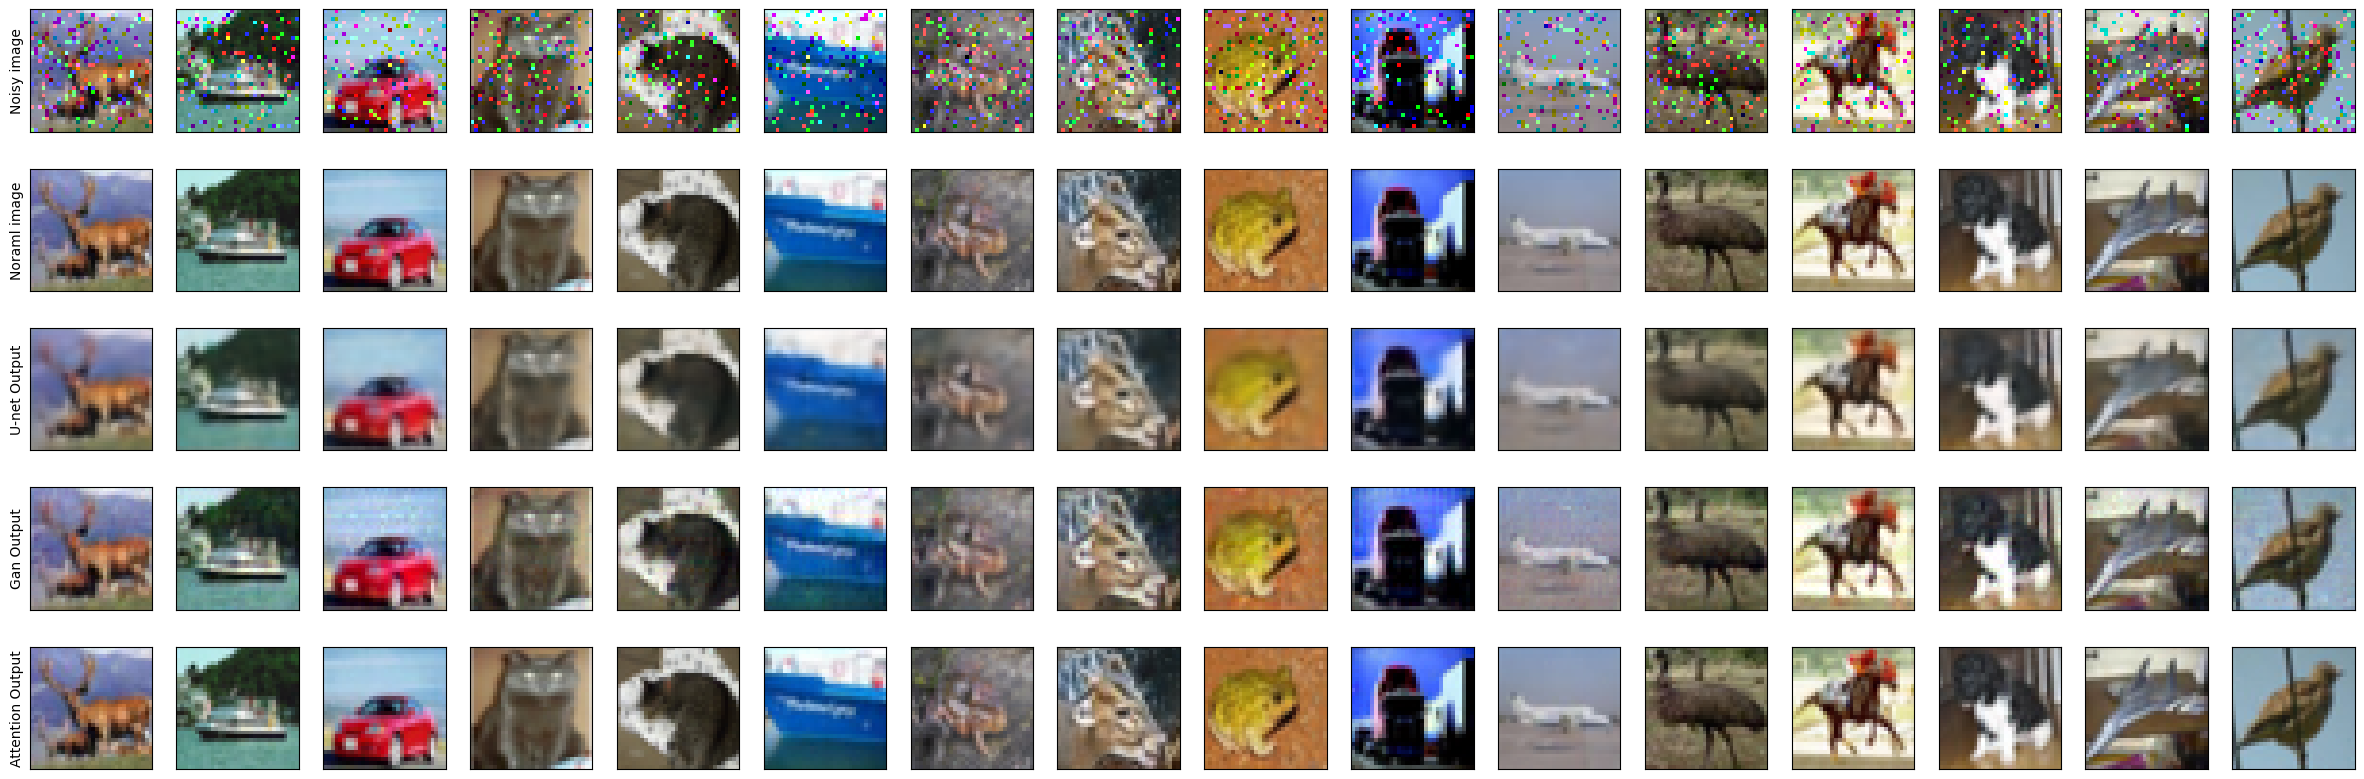

In [ ]:
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,10))
for idx in range(16):
    ax=fig.add_subplot(5, 16, idx+1, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noisy image')
    RGBshow(noise_imgs[idx])

    ax=fig.add_subplot(5, 16, idx+17, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noraml image')
    RGBshow(normal_imgs[idx])

    ax=fig.add_subplot(5, 16, idx+33, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('U-net Output')
    RGBshow(UNET_denoised_images[idx])

    ax=fig.add_subplot(5, 16, idx+49, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Gan Output')
    RGBshow(GAN_denoised_images[idx])

    ax=fig.add_subplot(5, 16, idx+65, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Attention Output')
    RGBshow(ATTENTION_denoised_images[idx])

# Compare the results

In [ ]:
import math
import numpy as np
import cv2

def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

In [ ]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def calculate_ssim(original, denoised):
    if not original.shape == denoised.shape:
        raise ValueError('Input images must have the same dimensions.')
    if original.ndim == 2:
        return calculate_ssim(original, denoised)
    elif original.ndim == 3:
        if original.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(calculate_ssim(original, denoised))
            return np.array(ssims).mean()
        elif original.shape[2] == 1:
            return calculate_ssim(np.squeeze(original), np.squeeze(denoised))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
import math

results = []

for index in range(len(normal_imgs)):

  noise_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), noise_imgs[index].detach().cpu().numpy())
  unet_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), UNET_denoised_images[index].detach().cpu().numpy())
  gan_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), GAN_denoised_images[index].detach().cpu().numpy())
  attention_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), ATTENTION_denoised_images[index].detach().cpu().numpy())
  gan_improvement = unet_psnr-gan_psnr
  attention_improvement = unet_psnr-attention_psnr
  result = {
    "index": index,
    "unet_psnr": unet_psnr,
    "gan_psnr": gan_psnr,
    "gan_improvement": gan_improvement,
    "attention_improvement": attention_improvement
  }    

  results.append(result)

sortedResults = sorted(results, key=lambda d: d['attention_improvement']) # print(normal_imgs[13].detach().cpu().numpy())


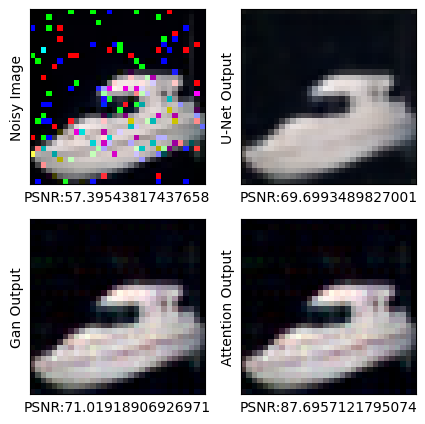

In [ ]:
index = sortedResults[0]["index"]
noise_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), noise_imgs[index].detach().cpu().numpy())
unet_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), UNET_denoised_images[index].detach().cpu().numpy())
gan_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), GAN_denoised_images[index].detach().cpu().numpy())

# print(f"Noisy Image is = {noise_psnr}")
# print(f"U-net denoised output is = {unet_psnr}")
# print(f"Gan denoised output is = {gan_psnr}")

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(5,5))

# ax=fig.add_subplot(2, 2, 1, xticks=[], yticks=[])
# plt.ylabel('Original')
# RGBshow(normal_imgs[index])

ax=fig.add_subplot(2, 2, 1, xticks=[], yticks=[])
plt.ylabel('Noisy Image')
plt.xlabel(f"PSNR:{noise_psnr}")
RGBshow(noise_imgs[index])

ax=fig.add_subplot(2, 2, 2, xticks=[], yticks=[])
plt.ylabel('U-Net Output')
plt.xlabel(f"PSNR:{unet_psnr}")
RGBshow(UNET_denoised_images[index])

ax=fig.add_subplot(2, 2, 3, xticks=[], yticks=[])
plt.ylabel('Gan Output')
plt.xlabel(f"PSNR:{gan_psnr}")
RGBshow(GAN_denoised_images[index])

ax=fig.add_subplot(2, 2, 4, xticks=[], yticks=[])
plt.ylabel('Attention Output')
plt.xlabel(f"PSNR:{attention_psnr}")
RGBshow(GAN_denoised_images[index])

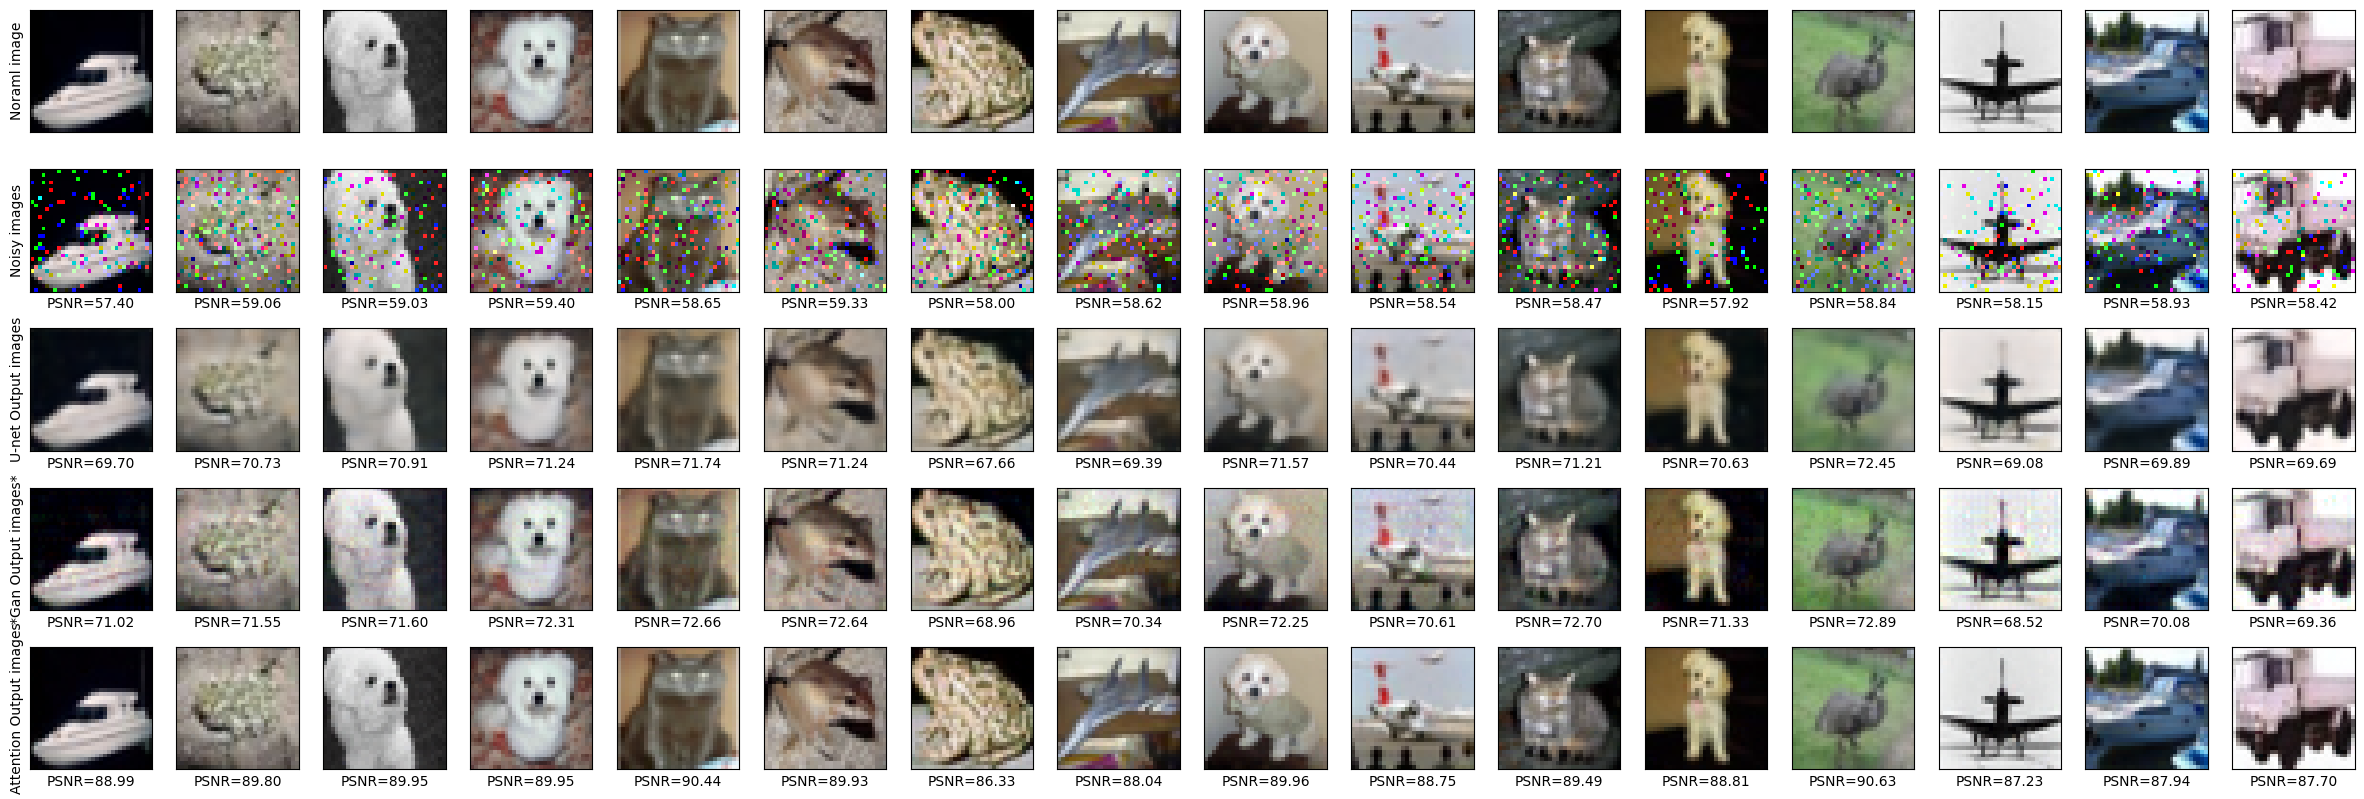

In [ ]:
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,10))
for idx in range(16):
    index = sortedResults[idx]["index"]
    noise_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), noise_imgs[index].detach().cpu().numpy())
    unet_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), UNET_denoised_images[index].detach().cpu().numpy())
    gan_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), GAN_denoised_images[index].detach().cpu().numpy())
    attention_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), ATTENTION_denoised_images[index].detach().cpu().numpy())

    ax=fig.add_subplot(5, 16, idx+1, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noraml image')
    RGBshow(normal_imgs[index])

    ax=fig.add_subplot(5, 16, idx+17, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noisy images')
    plt.xlabel("PSNR={:.2f}".format(noise_psnr))

    RGBshow(noise_imgs[index])

    ax=fig.add_subplot(5, 16, idx+33, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('U-net Output images')
    plt.xlabel("PSNR={:.2f}".format(unet_psnr))

    RGBshow(UNET_denoised_images[index])

    ax=fig.add_subplot(5, 16, idx+49, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('*Gan Output images*')
    plt.xlabel("PSNR={:.2f}".format(gan_psnr))

    RGBshow(GAN_denoised_images[index])

    ax=fig.add_subplot(5, 16, idx+65, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Attention Output images')
    plt.xlabel("PSNR={:.2f}".format(attention_psnr))

    RGBshow(ATTENTION_denoised_images[index])

# Extra: More Noise

In [ ]:
noise_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    SaltAndPepper(0.4)
])

In [ ]:
noisy_train_data=datasets.CIFAR10('noisy_data',train=True,download=True,transform=noise_transform)
noisy_test_data=datasets.CIFAR10('noisy_data',train=False,download=True,transform=noise_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_workers=1 # number of subprocesses to use for data loading
batch_size=64 
valid_size=0.2 # percentage of training set to use as validation
train_length = len(noisy_train_data)
indices=list(range(train_length)) # obtain training indices that will be used for validation
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices) # randomly shuffle data indeces

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

# define data loaders
noisy_train_loader=DataLoader(noisy_train_data,num_workers=num_workers,batch_size=batch_size,sampler=train_sampler)
noisy_validation_loader=DataLoader(noisy_train_data,num_workers=num_workers,batch_size=batch_size,sampler=validation_sampler)
noisy_test_loader=DataLoader(noisy_test_data,shuffle=True,num_workers=num_workers,batch_size=batch_size)


In [ ]:
noise_dataiter = iter(noisy_train_loader)
data = next(noise_dataiter)
(noise_imgs, normal_imgs), noise_labels = data
print(normal_imgs.size())

torch.Size([64, 3, 32, 32])


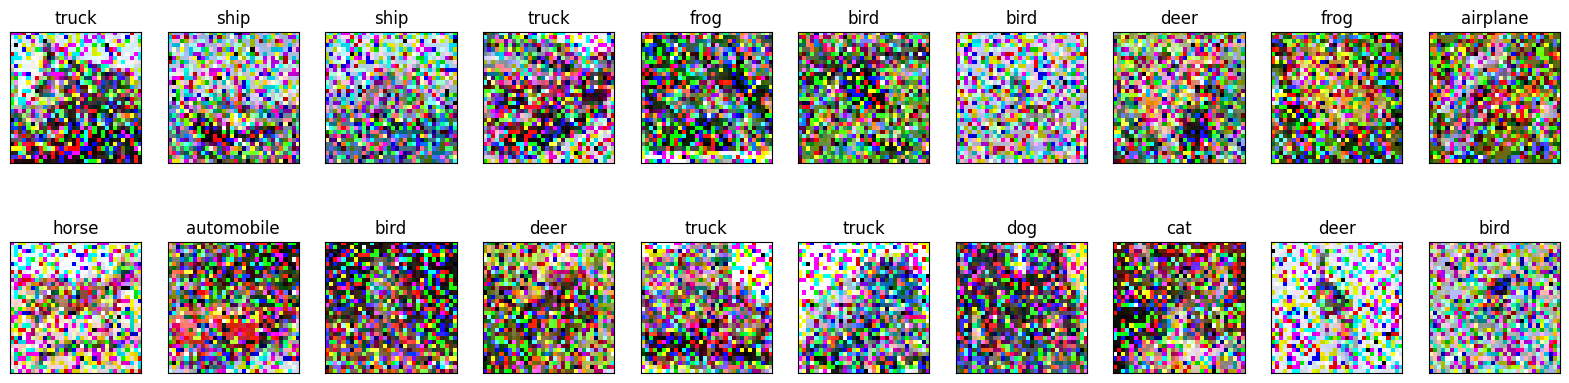

In [ ]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(20,5))
for idx in range(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    RGBshow(noise_imgs[idx])
    ax.set_title(classes[noise_labels[idx]])

In [ ]:
model = Unet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epoch = 20
valid_loss_min = np.Inf

model.to(device)
history = {'train': [], 'valid': []}
for i in range(epoch):
    print(f'Epoch {i+1} ...')
    
    model.train()
    sum_train_mse = 0
    training_steps = 0
    for (x, y), _ in tqdm(noisy_train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        
        sum_train_mse += loss.cpu().item()
        training_steps += 1

        loss.backward()
        optimizer.step()

    model.eval()
    sum_valid_mse = 0
    valid_steps = 0
    for (x, y), _ in tqdm(noisy_validation_loader):

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(x)
        loss = criterion(output, y)
        
        valid_loss = loss.cpu().item()
        sum_valid_mse += loss.cpu().item()
        valid_steps += 1

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'UNET-1-0.2.pt')
        valid_loss_min = valid_loss

    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1}, Average Train MSE: {sum_train_mse / training_steps}, Average Validation MSE: {sum_valid_mse / valid_steps}')

Epoch 1 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.026280). The new model saved
Epoch 1, Average Train MSE: 0.049924928206205366, Average Validation MSE: 0.023860989043572145
Epoch 2 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.026280 --> 0.012860). The new model saved
Epoch 2, Average Train MSE: 0.021927730420231818, Average Validation MSE: 0.012283604704792712
Epoch 3 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.012860 --> 0.007915). The new model saved
Epoch 3, Average Train MSE: 0.015409259441494941, Average Validation MSE: 0.009459308289276188
Epoch 4 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.007915 --> 0.004872). The new model saved
Epoch 4, Average Train MSE: 0.012297268684208393, Average Validation MSE: 0.005382694440425202
Epoch 5 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.004872 --> 0.004664). The new model saved
Epoch 5, Average Train MSE: 0.010895185391604901, Average Validation MSE: 0.004733379612896283
Epoch 6 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6, Average Train MSE: 0.01013587510511279, Average Validation MSE: 0.006558992621150746
Epoch 7 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7, Average Train MSE: 0.009292071764171123, Average Validation MSE: 0.006808412937554204
Epoch 8 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.004664 --> 0.004297). The new model saved
Epoch 8, Average Train MSE: 0.008898478700220584, Average Validation MSE: 0.004596896140367552
Epoch 9 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9, Average Train MSE: 0.008582557122409344, Average Validation MSE: 0.005643971922813328
Epoch 10 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.004297 --> 0.003430). The new model saved
Epoch 10, Average Train MSE: 0.008277770317345858, Average Validation MSE: 0.004052660413157598
Epoch 11 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11, Average Train MSE: 0.008046125082671642, Average Validation MSE: 0.004518162752768606
Epoch 12 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.003430 --> 0.002382). The new model saved
Epoch 12, Average Train MSE: 0.007875042393058538, Average Validation MSE: 0.0029503477464435965
Epoch 13 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13, Average Train MSE: 0.007777454224228859, Average Validation MSE: 0.003896636074219065
Epoch 14 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14, Average Train MSE: 0.007541766890138388, Average Validation MSE: 0.0036387240564581124
Epoch 15 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15, Average Train MSE: 0.007560080243647098, Average Validation MSE: 0.0031387885041819635
Epoch 16 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16, Average Train MSE: 0.007324885116517544, Average Validation MSE: 0.0031151652312392643
Epoch 17 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.002382 --> 0.002272). The new model saved
Epoch 17, Average Train MSE: 0.007266269604116678, Average Validation MSE: 0.0027050030266474578
Epoch 18 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18, Average Train MSE: 0.007295057558268309, Average Validation MSE: 0.002826070731837943
Epoch 19 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19, Average Train MSE: 0.007226635315269232, Average Validation MSE: 0.002626723893117278
Epoch 20 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20, Average Train MSE: 0.006932276961952448, Average Validation MSE: 0.002789354746698574


In [ ]:
model_save_name = 'UNET-1-0.2.pt'
path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
torch.save(model.state_dict(), path)

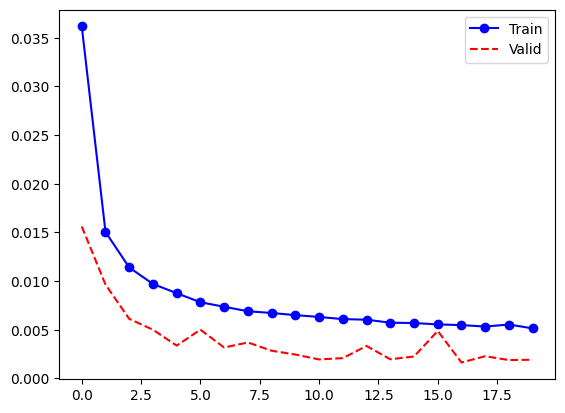

In [ ]:
plt.plot(history['train'], 'bo-', label='Train')
plt.plot(history['valid'], 'r--', label='Valid')
plt.legend()

In [ ]:
# model_save_name = 'UNET-1-0.2.pt'
# path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
# model.load_state_dict(torch.load(path))

In [ ]:
model.eval()

with torch.no_grad():
    noise_imgs = noise_imgs.to(device)
    UNET_denoised2_images = model(noise_imgs).cpu()

noise_imgs = noise_imgs.cpu()

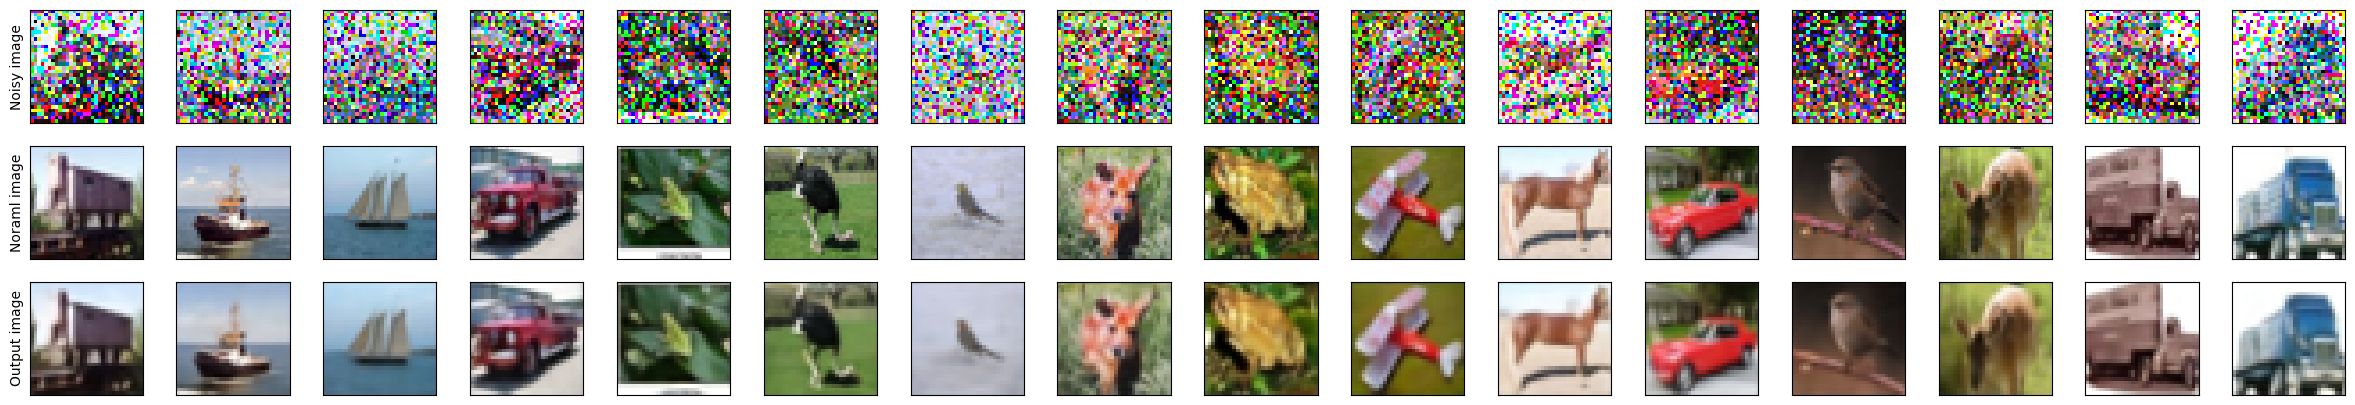

In [ ]:
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(16):
    ax=fig.add_subplot(3, 16, idx+1, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noisy image')
    RGBshow(noise_imgs[idx])

    ax=fig.add_subplot(3, 16, idx+17, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noraml image')
    RGBshow(normal_imgs[idx])

    ax=fig.add_subplot(3, 16, idx+33, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Output image')
    RGBshow(UNET_denoised2_images[idx])

In [ ]:
model =  UNetWithAttention()

In [ ]:
criterion = nn.MSELoss().to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch = 20
valid_loss_min = np.Inf

model.to(device)
history = {'train': [], 'valid': []}

for i in range(epoch):
    sum_train_mse = 0
    training_steps = 0
    print(f'Epoch {i+1} ...')
    
    #Train
    model.train()
    for (noisy_image, normal_image), _ in tqdm(noisy_train_loader):
    
        optimizer.zero_grad()

        noisy_image.to(device)
        normal_image.to(device)

        # Forward pass

        outputs = model(noisy_image.to(device)).to(device)
 
        loss = criterion(outputs, normal_image.to(device)).to(device)

        sum_train_mse += loss.cpu().item()
        training_steps += 1

        loss.backward()
        optimizer.step()

    #Validate
    model.eval()
    sum_valid_mse = 0
    valid_steps = 0

    with torch.no_grad():
        for (noisy_image, normal_image), _ in tqdm(noisy_validation_loader):

            noisy_image.to(device)
            normal_image.to(device)

            outputs = model(noisy_image.to(device)).to(device)

     

            loss = criterion(outputs, normal_image.to(device)).to(device)
            valid_loss = loss.cpu().item()
            sum_valid_mse += loss.cpu().item()
            valid_steps += 1

    if valid_loss <= valid_loss_min:

        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'Attention-UNET-0.2.pt')
        valid_loss_min = valid_loss

    history['train'].append(sum_train_mse / training_steps)
    history['valid'].append(sum_valid_mse / valid_steps)
    print(f'Epoch {i+1}, Average Train MSE: {sum_train_mse / training_steps}, Average Validation MSE: {sum_valid_mse / valid_steps}')

Epoch 1 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.023221). The new model saved
Epoch 1, Average Train MSE: 0.04077844292223454, Average Validation MSE: 0.023601151718075867
Epoch 2 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.023221 --> 0.009205). The new model saved
Epoch 2, Average Train MSE: 0.0141483776897192, Average Validation MSE: 0.010029833728245868
Epoch 3 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.009205 --> 0.008097). The new model saved
Epoch 3, Average Train MSE: 0.008550753216445446, Average Validation MSE: 0.009343130175902206
Epoch 4 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Average Train MSE: 0.006832474526017904, Average Validation MSE: 0.007425324757031764
Epoch 5 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.008097 --> 0.005633). The new model saved
Epoch 5, Average Train MSE: 0.005784394430369139, Average Validation MSE: 0.005255966960410973
Epoch 6 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6, Average Train MSE: 0.004886818949133158, Average Validation MSE: 0.00452999220449169
Epoch 7 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.005633 --> 0.003267). The new model saved
Epoch 7, Average Train MSE: 0.004337082619592547, Average Validation MSE: 0.0038027254194258507
Epoch 8 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8, Average Train MSE: 0.004164538610354066, Average Validation MSE: 0.0035591536931171537
Epoch 9 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9, Average Train MSE: 0.003667619497701526, Average Validation MSE: 0.0036498208109075857
Epoch 10 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.003267 --> 0.002600). The new model saved
Epoch 10, Average Train MSE: 0.0037003463193774223, Average Validation MSE: 0.002979491313824513
Epoch 11 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11, Average Train MSE: 0.0031582529734820127, Average Validation MSE: 0.004509838231228244
Epoch 12 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12, Average Train MSE: 0.003464647334814072, Average Validation MSE: 0.004914256919080475
Epoch 13 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.002600 --> 0.002505). The new model saved
Epoch 13, Average Train MSE: 0.003165283413231373, Average Validation MSE: 0.002526992531552626
Epoch 14 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14, Average Train MSE: 0.0028343202609568833, Average Validation MSE: 0.0026300037947074055
Epoch 15 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15, Average Train MSE: 0.006473675363510847, Average Validation MSE: 0.0038866663861806226
Epoch 16 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16, Average Train MSE: 0.0033666907913982866, Average Validation MSE: 0.002852711147349921
Epoch 17 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17, Average Train MSE: 0.002980982220172882, Average Validation MSE: 0.002601561031250912
Epoch 18 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.002505 --> 0.002293). The new model saved
Epoch 18, Average Train MSE: 0.002786890202201903, Average Validation MSE: 0.0026281993275591334
Epoch 19 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19, Average Train MSE: 0.00281867557503283, Average Validation MSE: 0.0026861281611713444
Epoch 20 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20, Average Train MSE: 0.002766801162995398, Average Validation MSE: 0.0023179595680480267


In [ ]:
model_save_name = 'Attention-UNET-0.2.pt'
path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
torch.save(model.state_dict(), path)

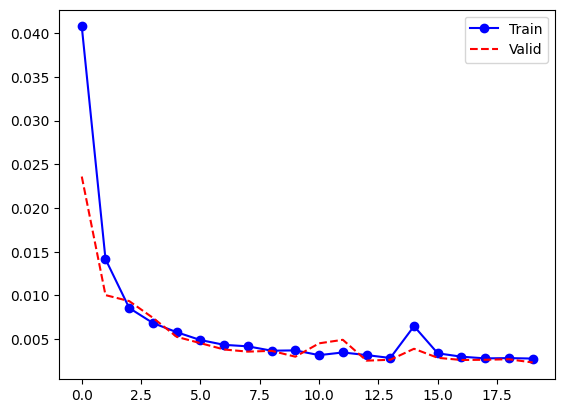

In [ ]:
plt.plot(history['train'], 'bo-', label='Train')
plt.plot(history['valid'], 'r--', label='Valid')
plt.legend()

In [ ]:
model_save_name = 'Attention-UNET-0.2.pt'
path = F"/content/drive/My Drive/Kian/DeepLearning/HW2/{model_save_name}" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model.eval()

with torch.no_grad():
    noise_imgs = noise_imgs.to(device)
    ATTENTION_denoised2_images = model(noise_imgs).cpu()

noise_imgs = noise_imgs.cpu()

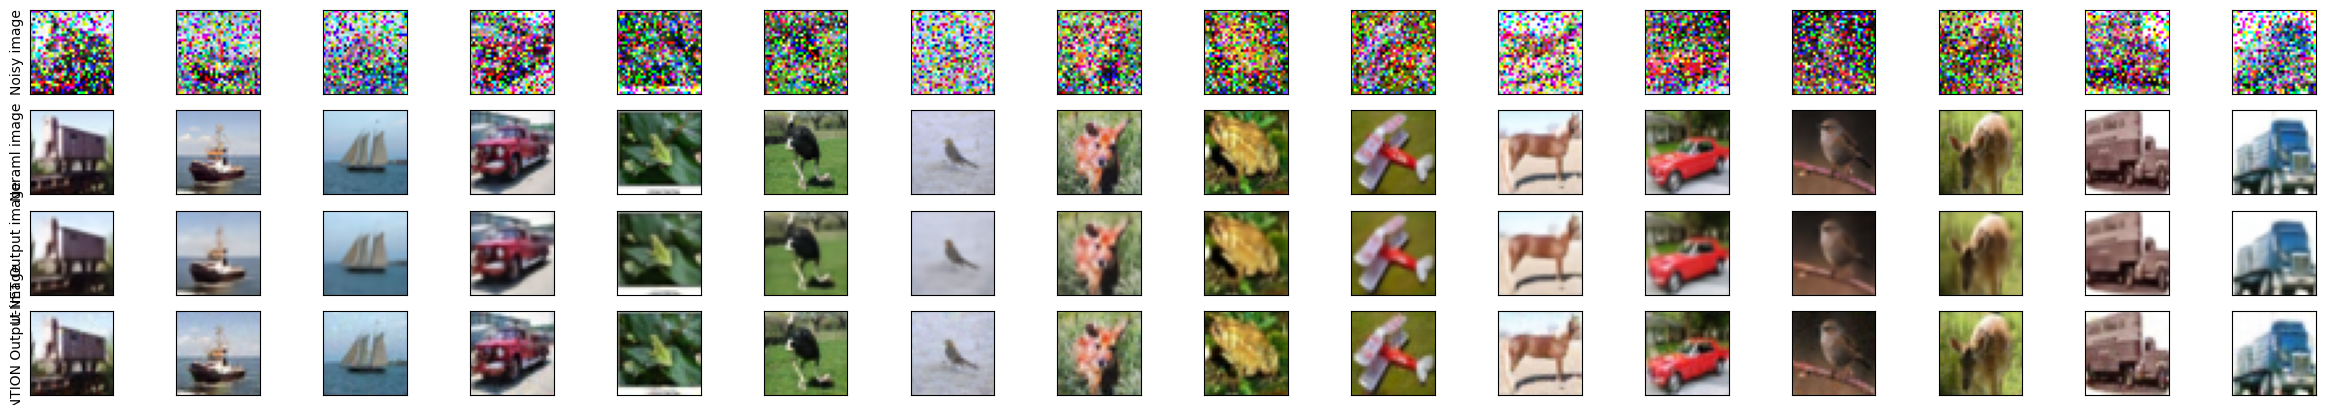

In [ ]:
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(16):
    ax=fig.add_subplot(4, 16, idx+1, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noisy image')
    RGBshow(noise_imgs[idx])

    ax=fig.add_subplot(4, 16, idx+17, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noraml image')
    RGBshow(normal_imgs[idx])

    ax=fig.add_subplot(4, 16, idx+33, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('U-NET Output image')
    RGBshow(UNET_denoised2_images[idx])

    ax=fig.add_subplot(4, 16, idx+49, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('ATTENTION Output image')
    RGBshow(ATTENTION_denoised2_images[idx])

In [ ]:
import math

results = []

for index in range(len(normal_imgs)):

  noise_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), noise_imgs[index].detach().cpu().numpy())
  unet_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), UNET_denoised2_images[index].detach().cpu().numpy())
  unet_ssim = calculate_ssim(normal_imgs[index].detach().cpu().numpy(), UNET_denoised2_images[index].detach().cpu().numpy())
  attention_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), ATTENTION_denoised2_images[index].detach().cpu().numpy())
  attention_ssim = calculate_ssim(normal_imgs[index].detach().cpu().numpy(), ATTENTION_denoised2_images[index].detach().cpu().numpy())

  attention_improvement = unet_psnr-attention_psnr
  result = {
    "index": index,
    "unet_psnr": unet_psnr,
    "unet_ssim": unet_ssim,
    "attention_psnr": attention_psnr,
    "attention_ssim": attention_ssim,
    "attention_improvement": attention_improvement,
  }    

  results.append(result)

sortedResults = sorted(results, key=lambda d: d['attention_improvement']) # print(normal_imgs[13].detach().cpu().numpy())


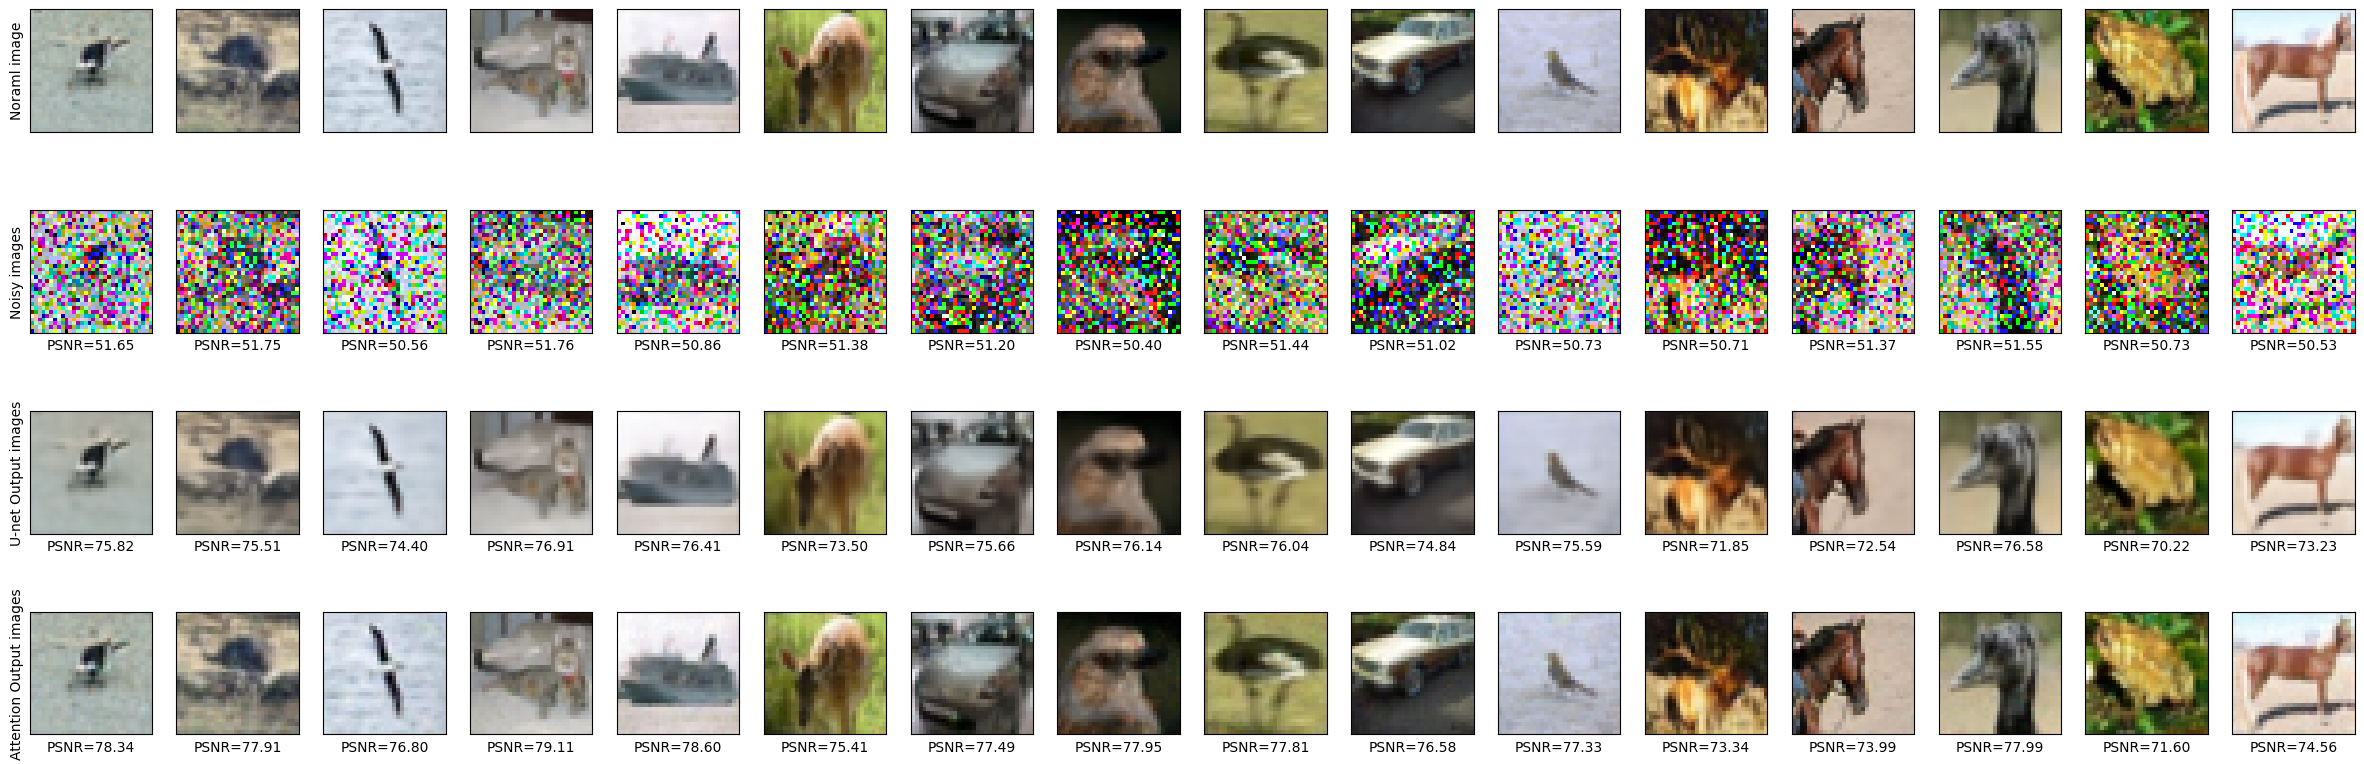

In [ ]:
def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,10))
for idx in range(16):
    index = sortedResults[idx]["index"]
    noise_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), noise_imgs[index].detach().cpu().numpy())
    unet_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), UNET_denoised2_images[index].detach().cpu().numpy())
    attention_psnr = PSNR(normal_imgs[index].detach().cpu().numpy(), ATTENTION_denoised2_images[index].detach().cpu().numpy())
   
    ax=fig.add_subplot(4, 16, idx+1, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noraml image')
    RGBshow(normal_imgs[index])

    ax=fig.add_subplot(4, 16, idx+17, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Noisy images')
    plt.xlabel("PSNR={:.2f}".format(noise_psnr))

    RGBshow(noise_imgs[index])

    ax=fig.add_subplot(4, 16, idx+33, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('U-net Output images')
    plt.xlabel("PSNR={:.2f}".format(unet_psnr))

    RGBshow(UNET_denoised2_images[index])

    ax=fig.add_subplot(4, 16, idx+49, xticks=[], yticks=[])
    if idx == 0:
        plt.ylabel('Attention Output images')
    plt.xlabel("PSNR={:.2f}".format(attention_psnr))

    RGBshow(ATTENTION_denoised2_images[index])